# Session based recommedation

- 웹 서버에 저장된 session 데이터를 기반으로 사용자에게 아이템을 추천해주는 시스템을 만들어보자.

## 1. 데이터 분석 및 전처리

#### MovieLes 데이터

1. 6040명의 유저가 3952개의 영화에 대해 1,000,209개의 평점을 부여한 데이터
2. UserID가 SessionID 역할을 한다.
3. 3년간의 정보가 모여있다.

In [1]:
# 데이터 설명(README)를 읽어 봅니다. 
import os
f = open(os.getenv('HOME')+'/aiffel/yoochoose/data/README', 'r')
while True:
    line = f.readline()
    if not line: break
    print(line)
f.close()

SUMMARY




These files contain 1,000,209 anonymous ratings of approximately 3,900 movies 

made by 6,040 MovieLens users who joined MovieLens in 2000.



USAGE LICENSE




Neither the University of Minnesota nor any of the researchers

involved can guarantee the correctness of the data, its suitability

for any particular purpose, or the validity of results based on the

use of the data set.  The data set may be used for any research

purposes under the following conditions:



     * The user may not state or imply any endorsement from the

       University of Minnesota or the GroupLens Research Group.



     * The user must acknowledge the use of the data set in

       publications resulting from the use of the data set

       (see below for citation information).



     * The user may not redistribute the data without separate

       permission.



     * The user may not use this information for any commercial or

       revenue-bearing purposes without first obtaining permi

___

#### 데이터 가져오기

- user_id : Sessionid
- movie_id : ItemId
- timestamp : Time

In [2]:
import datetime as dt
from pathlib import Path
import os

import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [3]:
data_path = Path(os.getenv('HOME')+'/aiffel/yoochoose/data') 
train_path = data_path / 'ratings.dat'
train_path

PosixPath('/aiffel/aiffel/yoochoose/data/ratings.dat')

Session, Time, Iteimid 컬럼만 불러오자

In [4]:
def load_data(data_path: Path, nrows=None):
    data = pd.read_csv(data_path, sep='::', encoding = 'ISO-8859-1')
    data.columns = ['user_id', 'movie_id', 'rating', 'timestamp']
    return data

In [5]:
# 시간이 좀 걸릴 수 있습니다. 메모리도 10GB 가까이 소요될 수 있으니 메모리 상태에 주의해 주세요.  
data = load_data(train_path, None)
data.sort_values(['user_id', 'timestamp'], inplace=True)  # data를 id와 시간 순서로 정렬해줍니다.
data.columns = ['SessionId','ItemId','rating','Time']
data

,SessionId,ItemId,rating,Time
30,1,3186,4,978300019
21,1,1270,5,978300055
26,1,1721,4,978300055
36,1,1022,5,978300055
23,1,2340,3,978300103
...,...,...,...,...
1000018,6040,2917,4,997454429
999987,6040,1921,4,997454464
1000171,6040,1784,3,997454464
1000166,6040,161,3,997454486


#### Sessionid, Itemid의 수

In [6]:
data['SessionId'].nunique(), data['ItemId'].nunique()

(6040, 3706)

#### Sessionid 별 방문 횟수

In [7]:
session_length = data.groupby('SessionId').size()
session_length

SessionId
1        52
2       129
3        51
4        21
5       198
       ... 
6036    888
6037    202
6038     20
6039    123
6040    341
Length: 6040, dtype: int64

#### 평균, 중앙값, 최대, 최소

In [8]:
session_length.median(), session_length.mean()

(96.0, 165.5973509933775)

In [9]:
session_length.min(), session_length.max()

(20, 2314)

#### 99.9%의 session id가 방문 횟수 1343 이하

방문 횟수 2314인 경우를 확인해보자!

In [10]:
session_length.quantile(0.999)

1343.181000000005

#### 매우 짧은 시간 간격으로 조회

- 동시에 여러 영화에 대한 평점을 저장?

- 삭제할 필요는 없다고 판단

In [11]:
long_session = session_length[session_length==2314].index[0]
data[data['SessionId']==long_session]

,SessionId,ItemId,rating,Time
696968,4169,1268,5,965333392
697167,4169,2617,4,965333392
697184,4169,2628,4,965333392
697218,4169,2653,4,965333392
697274,4169,423,3,965333392
...,...,...,...,...
697881,4169,3754,2,1024174347
695701,4169,1413,3,1024175031
697357,4169,494,4,1024175760
695944,4169,1804,2,1024175783


#### 시각화 해보기

In [12]:
length_count = session_length.groupby(session_length).size()
length_percent_cumsum = length_count.cumsum() / length_count.sum()
length_percent_cumsum_999 = length_percent_cumsum[length_percent_cumsum < 0.999]

length_percent_cumsum_999

20      0.014238
21      0.029305
22      0.042053
23      0.055464
24      0.068874
          ...   
1271    0.998179
1277    0.998344
1286    0.998510
1302    0.998675
1323    0.998841
Length: 736, dtype: float64

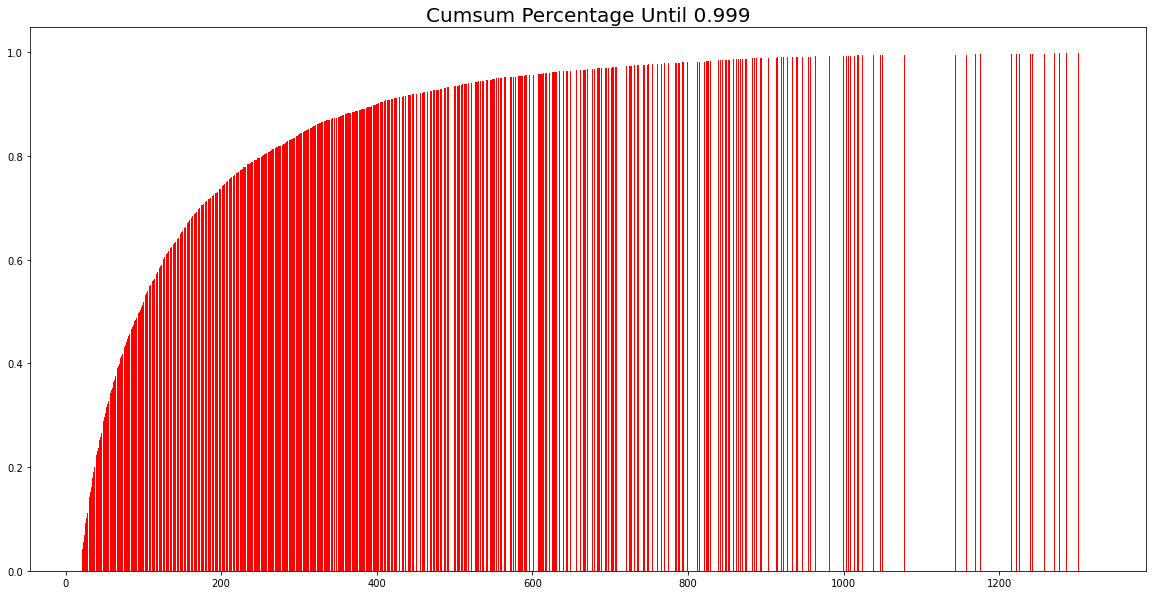

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
ax = plt.subplot()

ax.bar(x=length_percent_cumsum_999.index,
        height=length_percent_cumsum_999, color='red')
ax.set_title('Cumsum Percentage Until 0.999', size=20)
plt.show()

#### movie별 시청 횟수

In [14]:
Item_length = data.groupby('ItemId').size()
Item_length

ItemId
1       2077
2        701
3        478
4        170
5        296
        ... 
3948     862
3949     304
3950      54
3951      40
3952     388
Length: 3706, dtype: int64

In [15]:
Item_length.median(), Item_length.mean()

(123.5, 269.88882892606586)

In [16]:
Item_length.min(), Item_length.max()

(1, 3428)

#### movie 시청 횟수 시각화

In [17]:
length_count = Item_length.groupby(Item_length).size()
length_percent_cumsum = length_count.cumsum() / length_count.sum()
length_percent_cumsum_999 = length_percent_cumsum[length_percent_cumsum < 0.999]

length_percent_cumsum_999

1       0.030761
2       0.054776
3       0.066109
4       0.078251
5       0.088775
          ...   
2583    0.997841
2590    0.998111
2649    0.998381
2653    0.998651
2672    0.998921
Length: 920, dtype: float64

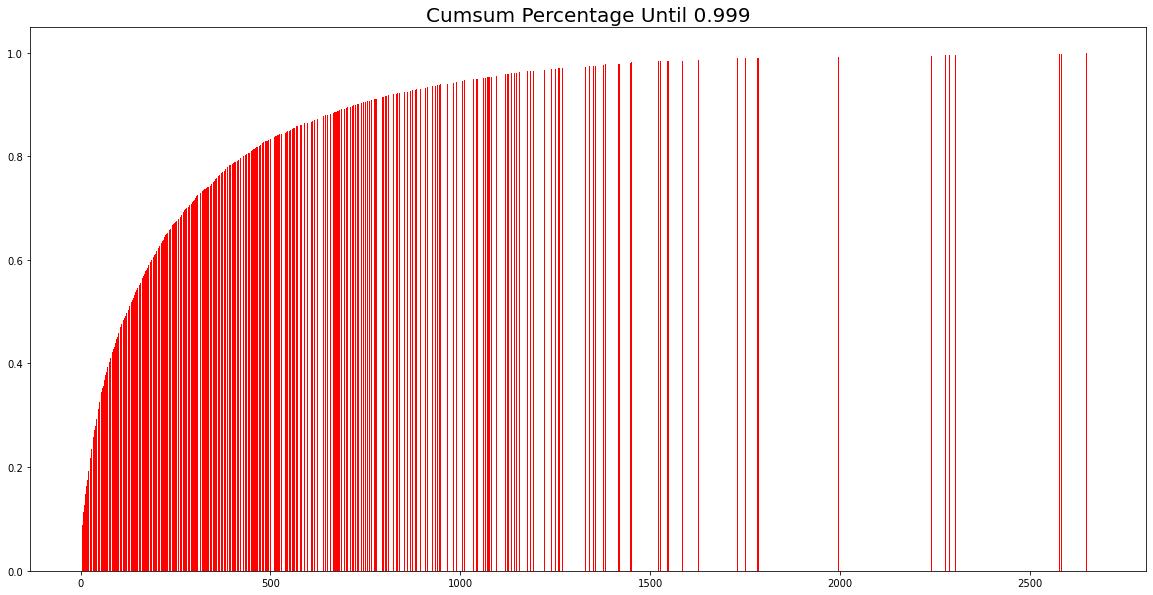

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
ax = plt.subplot()

ax.bar(x=length_percent_cumsum_999.index,
        height=length_percent_cumsum_999, color='red')
ax.set_title('Cumsum Percentage Until 0.999', size=20)
plt.show()

#### 시간 정보도 구매에 중요한 요소! 

시간 정보 확인해보기

#### timestamp -> date time

In [19]:
from datetime import datetime
import time

data['Time'] = data['Time'].apply(lambda x: datetime.fromtimestamp(x))
oldest, latest = data['Time'].min(), data['Time'].max()
print(oldest)
print(latest)

2000-04-25 23:05:32
2003-02-28 17:49:50


#### 날짜가 거의 2000년에 집중

latest 기준으로 날짜 뽑는 것은 의미 없다고 판단

In [20]:
data['Time'].median()

Timestamp('2000-10-31 18:46:46')

In [21]:
data['Time'].quantile(0.9)

Timestamp('2000-12-29 23:42:33.700000')

In [22]:
data['Time'].quantile(0.2)

Timestamp('2000-07-21 04:13:26.400000')

In [23]:
data['Time'].quantile(0.1)

Timestamp('2000-06-10 23:59:30')

#### 데이터 전처리

- 길이가 50이하 세션 제거
- 너무 적게 클릭된 아이템도 제거

In [24]:
# short_session을 제거한 다음 unpopular item을 제거하면 다시 길이가 1인 session이 생길 수 있습니다.
# 이를 위해 반복문을 통해 지속적으로 제거 합니다.
def cleanse_recursive(data: pd.DataFrame, shortest, least_click) -> pd.DataFrame:
    while True:
        before_len = len(data)
        data = cleanse_short_session(data, shortest)
        data = cleanse_unpopular_item(data, least_click)
        after_len = len(data)
        if before_len == after_len:
            break
    return data


def cleanse_short_session(data: pd.DataFrame, shortest):
    session_len = data.groupby('SessionId').size()
    session_use = session_len[session_len >= shortest].index
    data = data[data['SessionId'].isin(session_use)]
    return data


def cleanse_unpopular_item(data: pd.DataFrame, least_click):
    item_popular = data.groupby('ItemId').size()
    item_use = item_popular[item_popular >= least_click].index
    data = data[data['ItemId'].isin(item_use)]
    return data

#### 100명 이상의 평가를 받은 영화, 50개 이상의 영화를 판단한 사람만 데이터에 넣는다.

In [25]:
data = cleanse_recursive(data, shortest=50, least_click=100)
data

,SessionId,ItemId,rating,Time
30,1,3186,4,2000-12-31 22:00:19
21,1,1270,5,2000-12-31 22:00:55
26,1,1721,4,2000-12-31 22:00:55
36,1,1022,5,2000-12-31 22:00:55
23,1,2340,3,2000-12-31 22:01:43
...,...,...,...,...
1000018,6040,2917,4,2001-08-10 14:40:29
999987,6040,1921,4,2001-08-10 14:41:04
1000171,6040,1784,3,2001-08-10 14:41:04
1000166,6040,161,3,2001-08-10 14:41:26


#### 좋아했던 영화를 통해 추천하기 위해서 rating이 3 이상인 데이터만 남긴다.

In [26]:
data = data[data['rating'].apply(lambda x : x>=3)]
data

,SessionId,ItemId,rating,Time
30,1,3186,4,2000-12-31 22:00:19
21,1,1270,5,2000-12-31 22:00:55
26,1,1721,4,2000-12-31 22:00:55
36,1,1022,5,2000-12-31 22:00:55
23,1,2340,3,2000-12-31 22:01:43
...,...,...,...,...
1000018,6040,2917,4,2001-08-10 14:40:29
999987,6040,1921,4,2001-08-10 14:41:04
1000171,6040,1784,3,2001-08-10 14:41:04
1000166,6040,161,3,2001-08-10 14:41:26


___

#### Train/ Valid/ Test split

#### 현재 고객이 어떤 선택을 할 것인지가 중요하므로 날짜 별로 데이터를 나눈다.

3년치 데이터에서 마지막 50일을 test set, 그 이전 100일을 valid set으로 설정

날짜별 데이터 split

In [27]:
def split_by_date(data: pd.DataFrame, n_days: int):
    final_time = data['Time'].max()
    session_last_time = data.groupby('SessionId')['Time'].max() #sessionid 별 time 조회
    session_in_train = session_last_time[session_last_time < final_time - dt.timedelta(n_days)].index
    session_in_test = session_last_time[session_last_time >= final_time - dt.timedelta(n_days)].index

    before_date = data[data['SessionId'].isin(session_in_train)]
    after_date = data[data['SessionId'].isin(session_in_test)]
    after_date = after_date[after_date['ItemId'].isin(before_date['ItemId'])]
    return before_date, after_date

In [28]:
tr, test = split_by_date(data, n_days=50)
tr, val = split_by_date(tr, n_days=100)

#### 데이터별 정보 확인

In [29]:
# data에 대한 정보를 살펴봅니다.
def stats_info(data: pd.DataFrame, status: str):
    print(f'* {status} Set Stats Info\n'
          f'\t Events: {len(data)}\n'
          f'\t Sessions: {data["SessionId"].nunique()}\n'
          f'\t Items: {data["ItemId"].nunique()}\n'
          f'\t First Time : {data["Time"].min()}\n'
          f'\t Last Time : {data["Time"].max()}\n')

In [30]:
stats_info(tr, 'train')
stats_info(val, 'valid')
stats_info(test, 'test')

* train Set Stats Info
	 Events: 643751
	 Sessions: 3897
	 Items: 1971
	 First Time : 2000-04-25 23:05:32
	 Last Time : 2002-09-30 16:19:28

* valid Set Stats Info
	 Events: 46454
	 Sessions: 157
	 Items: 1965
	 First Time : 2000-04-27 16:38:08
	 Last Time : 2003-01-08 21:56:15

* test Set Stats Info
	 Events: 50627
	 Sessions: 139
	 Items: 1964
	 First Time : 2000-05-01 11:15:13
	 Last Time : 2003-02-28 17:49:50



#### 아이템 인덱싱

In [31]:
# train set에 없는 아이템이 val, test기간에 생길 수 있으므로 train data를 기준으로 인덱싱합니다.
id2idx = {item_id : index for index, item_id in enumerate(tr['ItemId'].unique())}

def indexing(df, id2idx):
    df['item_idx'] = df['ItemId'].map(lambda x: id2idx.get(x, -1))  # id2idx에 없는 아이템은 모르는 값(-1) 처리 해줍니다.
    return df

tr = indexing(tr, id2idx)
val = indexing(val, id2idx)
test = indexing(test, id2idx)

## 2 . 데이터 파이프라인 구축

데이터 pkl로 저장

In [32]:
save_path = data_path / 'processed' / 'movie'
save_path.mkdir(parents=True, exist_ok=True)

tr.to_pickle(save_path / 'train.pkl')
val.to_pickle(save_path / 'valid.pkl')
test.to_pickle(save_path / 'test.pkl')

주어진 데이터에서 세션이 시작되는 인덱스를 담는 값과 세션을 인덱싱한 값을 가지는 클래스 생성

In [33]:
class SessionDataset:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, data):
        self.df = data
        self.click_offsets = self.get_click_offsets()
        self.session_idx = np.arange(self.df['SessionId'].nunique())  # indexing to SessionId

    def get_click_offsets(self):
        """
        Return the indexes of the first click of each session IDs,
        """
        offsets = np.zeros(self.df['SessionId'].nunique() + 1, dtype=np.int32)
        offsets[1:] = self.df.groupby('SessionId').size().cumsum()
        return offsets

In [34]:
tr_dataset = SessionDataset(tr)
tr_dataset.df.head(20)

,SessionId,ItemId,rating,Time,item_idx
30,1,3186,4,2000-12-31 22:00:19,0
21,1,1270,5,2000-12-31 22:00:55,1
26,1,1721,4,2000-12-31 22:00:55,2
36,1,1022,5,2000-12-31 22:00:55,3
23,1,2340,3,2000-12-31 22:01:43,4
35,1,1836,5,2000-12-31 22:02:52,5
2,1,3408,4,2000-12-31 22:04:35,6
6,1,2804,5,2000-12-31 22:11:59,7
46,1,1207,4,2000-12-31 22:11:59,8
20,1,720,3,2000-12-31 22:12:40,9


In [35]:
session_len = tr_dataset.df.groupby('SessionId').size()
session_len

SessionId
1        51
2       112
3        46
5       125
6        67
       ... 
6035    136
6036    618
6037    181
6039    115
6040    254
Length: 3897, dtype: int64

세션이 시작되는(첫 클릭)인덱스

In [36]:
tr_dataset.click_offsets

array([     0,     51,    163, ..., 643382, 643497, 643751], dtype=int32)

세션 인덱싱

In [37]:
tr_dataset.session_idx

array([   0,    1,    2, ..., 3894, 3895, 3896])

#### generator 활용해서 session 정보 읽어오기

In [38]:
class SessionDataLoader:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, dataset: SessionDataset, batch_size=50):
        self.dataset = dataset
        self.batch_size = batch_size

    def __iter__(self):
        """ Returns the iterator for producing session-parallel training mini-batches.
        Yields:
            input (B,):  Item indices that will be encoded as one-hot vectors later.
            target (B,): a Variable that stores the target item indices
            masks: Numpy array indicating the positions of the sessions to be terminated
        """

        start, end, mask, last_session, finished = self.initialize()  # initialize 메소드에서 확인해주세요.
        """
        start : Index Where Session Start
        end : Index Where Session End
        mask : indicator for the sessions to be terminated
        """

        while not finished:
            min_len = (end - start).min() - 1  # Shortest Length Among Sessions
            for i in range(min_len):
                # Build inputs & targets
                inp = self.dataset.df['item_idx'].values[start + i]
                target = self.dataset.df['item_idx'].values[start + i + 1]
                yield inp, target, mask

            start, end, mask, last_session, finished = self.update_status(start, end, min_len, last_session, finished)

    def initialize(self):
        first_iters = np.arange(self.batch_size)    # 첫 배치에 사용할 세션 Index를 가져옵니다.
        last_session = self.batch_size - 1    # 마지막으로 다루고 있는 세션 Index를 저장해둡니다.
        start = self.dataset.click_offsets[self.dataset.session_idx[first_iters]]       # data 상에서 session이 시작된 위치를 가져옵니다.
        end = self.dataset.click_offsets[self.dataset.session_idx[first_iters] + 1]  # session이 끝난 위치 바로 다음 위치를 가져옵니다.
        mask = np.array([])   # session의 모든 아이템을 다 돌은 경우 mask에 추가해줄 것입니다.
        finished = False         # data를 전부 돌았는지 기록하기 위한 변수입니다.
        return start, end, mask, last_session, finished

    def update_status(self, start: np.ndarray, end: np.ndarray, min_len: int, last_session: int, finished: bool):  
        # 다음 배치 데이터를 생성하기 위해 상태를 update합니다.
        
        start += min_len   # __iter__에서 min_len 만큼 for문을 돌았으므로 start를 min_len 만큼 더해줍니다.
        mask = np.arange(self.batch_size)[(end - start) == 1]  
        # end는 다음 세션이 시작되는 위치인데 start와 한 칸 차이난다는 것은 session이 끝났다는 뜻입니다. mask에 기록해줍니다.

        for i, idx in enumerate(mask, start=1):  # mask에 추가된 세션 개수만큼 새로운 세션을 돌것입니다.
            new_session = last_session + i  
            if new_session > self.dataset.session_idx[-1]:  # 만약 새로운 세션이 마지막 세션 index보다 크다면 모든 학습데이터를 돈 것입니다.
                finished = True
                break
            # update the next starting/ending point
            start[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session]]     # 종료된 세션 대신 새로운 세션의 시작점을 기록합니다.
            end[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session] + 1]

        last_session += len(mask)  # 마지막 세션의 위치를 기록해둡니다.
        return start, end, mask, last_session, finished

In [39]:
tr_data_loader = SessionDataLoader(tr_dataset, batch_size=4)
tr_dataset.df.head(20)

,SessionId,ItemId,rating,Time,item_idx
30,1,3186,4,2000-12-31 22:00:19,0
21,1,1270,5,2000-12-31 22:00:55,1
26,1,1721,4,2000-12-31 22:00:55,2
36,1,1022,5,2000-12-31 22:00:55,3
23,1,2340,3,2000-12-31 22:01:43,4
35,1,1836,5,2000-12-31 22:02:52,5
2,1,3408,4,2000-12-31 22:04:35,6
6,1,2804,5,2000-12-31 22:11:59,7
46,1,1207,4,2000-12-31 22:11:59,8
20,1,720,3,2000-12-31 22:12:40,9


In [40]:
iter_ex = iter(tr_data_loader)

iter를 통해 계속 다음 데이터를 만들 수 있다.

In [41]:
inputs, labels, mask =  next(iter_ex)
print(f'Model Input Item Idx are : {inputs}')
print(f'Label Item Idx are : {"":5} {labels}')
print(f'Previous Masked Input Idx are {mask}')

Model Input Item Idx are : [  0  51  63 187]
Label Item Idx are :       [ 1 52 61 11]
Previous Masked Input Idx are []


___

## 3. 모델 설계

### 모델 소개

#### GRU4REC

- GRU 기반

 - Embedding layer보다 one-hot encoding 때 더 좋은 결과

![image](https://user-images.githubusercontent.com/86637320/131254052-3ed7e72c-66f9-4de3-a4a1-884e364e6bfe.png)

- 세션 별로 미니 배치 생성 시 세션 길이에 따라서 병목 현상 발생 우려

![image](https://user-images.githubusercontent.com/86637320/131254118-07785670-642d-403a-949b-b1db041c0d0d.png)

- Session-Parallel Mini-Batches

#### 성능 평가 지표

-  MRR과 Recall@k

순서에 민감한 MRR

In [42]:
def mrr_k(pred, truth: int, k: int):
    indexing = np.where(pred[:k] == truth)[0]
    if len(indexing) > 0:
        return 1 / (indexing[0] + 1)
    else:
        return 0


def recall_k(pred, truth: int, k: int) -> int:
    answer = truth in pred[:k]
    return int(answer)

#### 모델 선언

In [43]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, GRU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

In [44]:
def create_model(args):
    inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU')(inputs)
    dropout = Dropout(args.drop_rate)(gru)
    predictions = Dense(args.num_items, activation='softmax')(dropout)
    model = Model(inputs=inputs, outputs=[predictions])
    model.compile(loss=categorical_crossentropy, optimizer=Adam(args.lr), metrics=['accuracy'])
    model.summary()
    return model

#### 하이퍼 파라미터를 클래스로 관리

In [45]:
class Args:
    def __init__(self, tr, val, test, batch_size, hsz, drop_rate, lr, epochs, k):
        self.tr = tr
        self.val = val
        self.test = test
        self.num_items = tr['ItemId'].nunique()
        self.num_sessions = tr['SessionId'].nunique()
        self.batch_size = batch_size
        self.hsz = hsz
        self.drop_rate = drop_rate
        self.lr = lr
        self.epochs = epochs
        self.k = k

#args 지정
args = Args(tr, val, test, batch_size=128, hsz=50, drop_rate=0.1, lr=0.001, epochs=10, k=20)

In [46]:
model = create_model(args)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(128, 1, 1971)]          0         
_________________________________________________________________
GRU (GRU)                    [(128, 50), (128, 50)]    303450    
_________________________________________________________________
dropout (Dropout)            (128, 50)                 0         
_________________________________________________________________
dense (Dense)                (128, 1971)               100521    
Total params: 403,971
Trainable params: 403,971
Non-trainable params: 0
_________________________________________________________________


#### 모델 훈련하기

In [47]:
# train 셋으로 학습하면서 valid 셋으로 검증합니다.
def train_model(model, args):
    train_dataset = SessionDataset(args.tr)
    train_loader = SessionDataLoader(train_dataset, batch_size=args.batch_size)

    for epoch in range(1, args.epochs + 1):
        total_step = len(args.tr) - args.tr['SessionId'].nunique()
        tr_loader = tqdm(train_loader, total=total_step // args.batch_size, desc='Train', mininterval=1)
        for feat, target, mask in tr_loader:
            reset_hidden_states(model, mask)  # 종료된 session은 hidden_state를 초기화합니다. 아래 메서드에서 확인해주세요.

            input_ohe = to_categorical(feat, num_classes=args.num_items)
            input_ohe = np.expand_dims(input_ohe, axis=1)
            target_ohe = to_categorical(target, num_classes=args.num_items)

            result = model.train_on_batch(input_ohe, target_ohe)
            tr_loader.set_postfix(train_loss=result[0], accuracy = result[1])

        val_recall, val_mrr = get_metrics(args.val, model, args, args.k)  # valid set에 대해 검증합니다.

        print(f"\t - Recall@{args.k} epoch {epoch}: {val_recall:3f}")
        print(f"\t - MRR@{args.k}    epoch {epoch}: {val_mrr:3f}\n")


def reset_hidden_states(model, mask):
    gru_layer = model.get_layer(name='GRU')  # model에서 gru layer를 가져옵니다.
    hidden_states = gru_layer.states[0].numpy()  # gru_layer의 parameter를 가져옵니다.
    for elt in mask:  # mask된 인덱스 즉, 종료된 세션의 인덱스를 돌면서
        hidden_states[elt, :] = 0  # parameter를 초기화 합니다.
    gru_layer.reset_states(states=hidden_states)


def get_metrics(data, model, args, k: int):  # valid셋과 test셋을 평가하는 코드입니다. 
                                             # train과 거의 같지만 mrr, recall을 구하는 라인이 있습니다.
    dataset = SessionDataset(data)
    loader = SessionDataLoader(dataset, batch_size=args.batch_size)
    recall_list, mrr_list = [], []

    total_step = len(data) - data['SessionId'].nunique()
    for inputs, label, mask in tqdm(loader, total=total_step // args.batch_size, desc='Evaluation', mininterval=1):
        reset_hidden_states(model, mask)
        input_ohe = to_categorical(inputs, num_classes=args.num_items)
        input_ohe = np.expand_dims(input_ohe, axis=1)

        pred = model.predict(input_ohe, batch_size=args.batch_size)
        pred_arg = tf.argsort(pred, direction='DESCENDING')  # softmax 값이 큰 순서대로 sorting 합니다.

        length = len(inputs)
        recall_list.extend([recall_k(pred_arg[i], label[i], k) for i in range(length)])
        mrr_list.extend([mrr_k(pred_arg[i], label[i], k) for i in range(length)])

    recall, mrr = np.mean(recall_list), np.mean(mrr_list)
    return recall, mrr

In [48]:
# 학습 시간이 다소 오래 소요됩니다. (예상시간 1시간)
train_model(model, args)

Train:   0%|          | 0/4998 [00:00<?, ?it/s, accuracy=0.0312, train_loss=5.6]  

	 - Recall@20 epoch 1: 0.245733
	 - MRR@20    epoch 1: 0.063671



Train:   0%|          | 0/4998 [00:00<?, ?it/s, accuracy=0.0469, train_loss=5.23]

	 - Recall@20 epoch 2: 0.305344
	 - MRR@20    epoch 2: 0.083781



Train:   0%|          | 0/4998 [00:00<?, ?it/s, accuracy=0.0391, train_loss=5.14] 

	 - Recall@20 epoch 3: 0.329372
	 - MRR@20    epoch 3: 0.094796



Train:   0%|          | 0/4998 [00:00<?, ?it/s, accuracy=0.0234, train_loss=5.08]

	 - Recall@20 epoch 4: 0.341321
	 - MRR@20    epoch 4: 0.100756



Train:   0%|          | 0/4998 [00:00<?, ?it/s, accuracy=0.0391, train_loss=5.02] 

	 - Recall@20 epoch 5: 0.347886
	 - MRR@20    epoch 5: 0.104231



Train:   0%|          | 0/4998 [00:00<?, ?it/s, accuracy=0.0391, train_loss=5.01]

	 - Recall@20 epoch 6: 0.352285
	 - MRR@20    epoch 6: 0.106197



Train:   0%|          | 0/4998 [00:00<?, ?it/s, accuracy=0.0625, train_loss=4.86]

	 - Recall@20 epoch 7: 0.353335
	 - MRR@20    epoch 7: 0.107640



Train:   0%|          | 0/4998 [00:00<?, ?it/s, accuracy=0.0781, train_loss=4.88]

	 - Recall@20 epoch 8: 0.353335
	 - MRR@20    epoch 8: 0.108805



Train:   0%|          | 0/4998 [00:00<?, ?it/s, accuracy=0.0547, train_loss=4.88] 

	 - Recall@20 epoch 9: 0.354123
	 - MRR@20    epoch 9: 0.109590



Evaluation:  33%|███▎      | 119/361 [01:20<02:44,  1.48it/s]

	 - Recall@20 epoch 10: 0.355633
	 - MRR@20    epoch 10: 0.110155



#### 학습된 결과 검증

In [49]:
def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 20)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

test_model(model, args, test)

Evaluation:  24%|██▍       | 95/394 [01:04<03:22,  1.48it/s]

	 - Recall@20: 0.343997
	 - MRR@20: 0.106607



___

## 4. 모델 개선 시도

### 1. Batch size 변화

#### batch size : 64

- batch size : 128일 때 보다 느린 훈련 속도, 낮은 MRR, Recall.

-  loss가 꾸준히 줄어드는 것이 아니기 때문에 epoch를 늘리더라도 개선되지 않을 것이라고 판단.

In [52]:
# 학습 시간이 다소 오래 소요됩니다. (예상시간 1시간)
train_model(model, args)

Train:   0%|          | 0/9997 [00:00<?, ?it/s, accuracy=0.0469, train_loss=5.36]

	 - Recall@20 epoch 1: 0.236577
	 - MRR@20    epoch 1: 0.059915



Train:   0%|          | 0/9997 [00:00<?, ?it/s, accuracy=0.0781, train_loss=5.11]

	 - Recall@20 epoch 2: 0.279953
	 - MRR@20    epoch 2: 0.075449



Train:   0%|          | 0/9997 [00:00<?, ?it/s, accuracy=0.0469, train_loss=4.98]

	 - Recall@20 epoch 3: 0.293436
	 - MRR@20    epoch 3: 0.081790



Train:   0%|          | 0/9997 [00:00<?, ?it/s, accuracy=0.0938, train_loss=5.05]

	 - Recall@20 epoch 4: 0.298383
	 - MRR@20    epoch 4: 0.085112



Train:   0%|          | 0/9997 [00:00<?, ?it/s, accuracy=0.0625, train_loss=4.96]

	 - Recall@20 epoch 5: 0.301731
	 - MRR@20    epoch 5: 0.087314



Train:   0%|          | 0/9997 [00:00<?, ?it/s, accuracy=0.0781, train_loss=5.14]

	 - Recall@20 epoch 6: 0.301188
	 - MRR@20    epoch 6: 0.088251



Train:   0%|          | 0/9997 [00:00<?, ?it/s, accuracy=0.0625, train_loss=5.06]

	 - Recall@20 epoch 7: 0.302546
	 - MRR@20    epoch 7: 0.088974



Train:   0%|          | 0/9997 [00:00<?, ?it/s, accuracy=0.0781, train_loss=5.07]

	 - Recall@20 epoch 8: 0.303059
	 - MRR@20    epoch 8: 0.088964



Train:   0%|          | 0/9997 [00:00<?, ?it/s, accuracy=0.0469, train_loss=5.02]

	 - Recall@20 epoch 9: 0.303240
	 - MRR@20    epoch 9: 0.089238



Evaluation:  72%|███████▏  | 518/723 [03:05<01:13,  2.79it/s]

	 - Recall@20 epoch 10: 0.303149
	 - MRR@20    epoch 10: 0.089995



In [53]:
def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 20)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

test_model(model, args, test)

Evaluation:  69%|██████▉   | 543/788 [03:10<01:25,  2.85it/s]

	 - Recall@20: 0.285653
	 - MRR@20: 0.083424



___

### 2. Dropout rate 조정

Dropout rate 조정에 따른 큰 변화는 없었다.

#### Dropout rate를 0.4로 조정

In [61]:
# 학습 시간이 다소 오래 소요됩니다. (예상시간 1시간)
train_model(model, args)

Train:   0%|          | 0/4998 [00:00<?, ?it/s, accuracy=0.0312, train_loss=5.95] 

	 - Recall@20 epoch 1: 0.220720
	 - MRR@20    epoch 1: 0.054460



Train:   0%|          | 0/4998 [00:00<?, ?it/s, accuracy=0.0156, train_loss=5.63] 

	 - Recall@20 epoch 2: 0.285123
	 - MRR@20    epoch 2: 0.076109



Train:   0%|          | 0/4998 [00:00<?, ?it/s, accuracy=0.0156, train_loss=5.37] 

	 - Recall@20 epoch 3: 0.314404
	 - MRR@20    epoch 3: 0.086013



Train:   0%|          | 0/4998 [00:00<?, ?it/s, accuracy=0.0391, train_loss=5.23] 

	 - Recall@20 epoch 4: 0.328650
	 - MRR@20    epoch 4: 0.092963



Train:   0%|          | 0/4998 [00:00<?, ?it/s, accuracy=0.0547, train_loss=5.18]

	 - Recall@20 epoch 5: 0.333246
	 - MRR@20    epoch 5: 0.096137



Train:   0%|          | 0/4998 [00:00<?, ?it/s, accuracy=0.0469, train_loss=5.26] 

	 - Recall@20 epoch 6: 0.340533
	 - MRR@20    epoch 6: 0.099467



Train:   0%|          | 0/4998 [00:00<?, ?it/s, accuracy=0.00781, train_loss=5.26]

	 - Recall@20 epoch 7: 0.343881
	 - MRR@20    epoch 7: 0.101782



Train:   0%|          | 0/4998 [00:00<?, ?it/s, accuracy=0.0391, train_loss=5.27]

	 - Recall@20 epoch 8: 0.347952
	 - MRR@20    epoch 8: 0.102938



Train:   0%|          | 0/4998 [00:00<?, ?it/s, accuracy=0.0234, train_loss=5.21] 

	 - Recall@20 epoch 9: 0.350249
	 - MRR@20    epoch 9: 0.103770



Evaluation:  33%|███▎      | 119/361 [01:16<02:36,  1.55it/s]

	 - Recall@20 epoch 10: 0.351169
	 - MRR@20    epoch 10: 0.105086



In [62]:
def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 20)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

test_model(model, args, test)

Evaluation:  24%|██▍       | 95/394 [01:02<03:15,  1.53it/s]

	 - Recall@20: 0.339803
	 - MRR@20: 0.100476



#### dropout 0.2

In [65]:
# 학습 시간이 다소 오래 소요됩니다. (예상시간 1시간)
train_model(model, args)

Train:   0%|          | 0/4998 [00:00<?, ?it/s, accuracy=0.0156, train_loss=5.79] 

	 - Recall@20 epoch 1: 0.236738
	 - MRR@20    epoch 1: 0.059651



Train:   0%|          | 0/4998 [00:00<?, ?it/s, accuracy=0.0391, train_loss=5.35] 

	 - Recall@20 epoch 2: 0.303309
	 - MRR@20    epoch 2: 0.082522



Train:   0%|          | 0/4998 [00:00<?, ?it/s, accuracy=0.0312, train_loss=5.24] 

	 - Recall@20 epoch 3: 0.328453
	 - MRR@20    epoch 3: 0.093016



Train:   0%|          | 0/4998 [00:00<?, ?it/s, accuracy=0.0469, train_loss=5.1] 

	 - Recall@20 epoch 4: 0.339745
	 - MRR@20    epoch 4: 0.099386



Train:   0%|          | 0/4998 [00:00<?, ?it/s, accuracy=0.0469, train_loss=5.21]

	 - Recall@20 epoch 5: 0.344144
	 - MRR@20    epoch 5: 0.102467



Train:   0%|          | 0/4998 [00:00<?, ?it/s, accuracy=0.0234, train_loss=5.19]

	 - Recall@20 epoch 6: 0.349265
	 - MRR@20    epoch 6: 0.105544



Train:   0%|          | 0/4998 [00:00<?, ?it/s, accuracy=0.0312, train_loss=5.18] 

	 - Recall@20 epoch 7: 0.352744
	 - MRR@20    epoch 7: 0.107255



Train:   0%|          | 0/4998 [00:00<?, ?it/s, accuracy=0.0547, train_loss=5.09] 

	 - Recall@20 epoch 8: 0.353072
	 - MRR@20    epoch 8: 0.108285



Train:   0%|          | 0/4998 [00:00<?, ?it/s, accuracy=0.0469, train_loss=5.11] 

	 - Recall@20 epoch 9: 0.355108
	 - MRR@20    epoch 9: 0.109583



Evaluation:  33%|███▎      | 119/361 [01:16<02:35,  1.56it/s]

	 - Recall@20 epoch 10: 0.356683
	 - MRR@20    epoch 10: 0.109884



In [66]:
def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 20)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

test_model(model, args, test)

Evaluation:  24%|██▍       | 95/394 [01:01<03:14,  1.53it/s]

	 - Recall@20: 0.347204
	 - MRR@20: 0.106040



___

### 3. Session 분포 재조정

 - 분포를 조정한 결과 더 안 좋은 결과가 나왔다.

In [72]:
stats_info(tr, 'train')
stats_info(val, 'valid')
stats_info(test, 'test')

* train Set Stats Info
	 Events: 569403
	 Sessions: 3617
	 Items: 1971
	 First Time : 2000-04-25 23:05:32
	 Last Time : 2001-12-03 07:56:51

* valid Set Stats Info
	 Events: 74348
	 Sessions: 280
	 Items: 1969
	 First Time : 2000-04-27 01:55:48
	 Last Time : 2002-09-30 16:19:28

* test Set Stats Info
	 Events: 97081
	 Sessions: 296
	 Items: 1971
	 First Time : 2000-04-27 16:38:08
	 Last Time : 2003-02-28 17:49:50



In [81]:
# 학습 시간이 다소 오래 소요됩니다. (예상시간 1시간)
train_model(model, args)

Train:   0%|          | 0/4420 [00:00<?, ?it/s, accuracy=0.00781, train_loss=5.8] 

	 - Recall@20 epoch 1: 0.191465
	 - MRR@20    epoch 1: 0.046183



Train:   0%|          | 0/4420 [00:00<?, ?it/s, accuracy=0.0469, train_loss=5.35] 

	 - Recall@20 epoch 2: 0.255869
	 - MRR@20    epoch 2: 0.068182



Train:   0%|          | 0/4420 [00:00<?, ?it/s, accuracy=0.0312, train_loss=5.24] 

	 - Recall@20 epoch 3: 0.281348
	 - MRR@20    epoch 3: 0.078160



Train:   0%|          | 0/4420 [00:00<?, ?it/s, accuracy=0.0312, train_loss=5.01] 

	 - Recall@20 epoch 4: 0.293774
	 - MRR@20    epoch 4: 0.083467



Train:   0%|          | 0/4420 [00:00<?, ?it/s, accuracy=0.0547, train_loss=5.03] 

	 - Recall@20 epoch 5: 0.302234
	 - MRR@20    epoch 5: 0.087145



Train:   0%|          | 0/4420 [00:00<?, ?it/s, accuracy=0.0469, train_loss=5.01] 

	 - Recall@20 epoch 6: 0.305060
	 - MRR@20    epoch 6: 0.089301



Train:   0%|          | 0/4420 [00:00<?, ?it/s, accuracy=0.0391, train_loss=4.89] 

	 - Recall@20 epoch 7: 0.307750
	 - MRR@20    epoch 7: 0.091392



Train:   0%|          | 0/4420 [00:00<?, ?it/s, accuracy=0.0469, train_loss=4.9]  

	 - Recall@20 epoch 8: 0.310714
	 - MRR@20    epoch 8: 0.092661



Train:   0%|          | 0/4420 [00:00<?, ?it/s, accuracy=0.0703, train_loss=4.88] 

	 - Recall@20 epoch 9: 0.311244
	 - MRR@20    epoch 9: 0.093432



Evaluation:  69%|██████▉   | 398/578 [04:22<01:58,  1.52it/s]

	 - Recall@20 epoch 10: 0.312500
	 - MRR@20    epoch 10: 0.094079



In [82]:
def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 20)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

test_model(model, args, test)

Evaluation:  69%|██████▉   | 525/756 [05:50<02:34,  1.50it/s]

	 - Recall@20: 0.296711
	 - MRR@20: 0.087815



___

## 5. 정리

- Session based recommendation을 movielens 데이터를 이용해 적용해 보았다.

movielens의 user_id를 session_id처럼 판단해서 GRU 구조에 적용해 결과를 얻고자 했지만 user_id는 session_id와 달리 유저마다 고유의 값이 할당되기 때문에 session based recommendation을 통해선 좋은 결과를 얻을 수 없었다.

- movielens user_id 기반 추천 시스템을 구성하기 위해선 MF 추천 시스템을 활용하는 것이 더 효율적일 것이다.

이때 movie_id 기반으로 클러스터링을 진행한 뒤 얻은 결과를 학습에 활용하는 것도 한 방법이다.

Dropout rate , Batch size, Session 분포 조정을 시도했지만 초기 설정값과 비교할때 큰 성능 향상이 없었다. 